In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, precision_recall_curve,  roc_curve, auc, precision_score
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
# Loading data
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/My Drive/bioresponse.csv")
df.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Part 1
# Splitting the data into a training and  test samples

X = df.drop('Activity', axis=1)
y = df['Activity']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=123)
print(f"The size of the train sample: {X_train.shape}")
print(f"The size of the test sample: {X_test.shape}")

The size of the train sample: (2813, 1776)
The size of the test sample: (938, 1776)


In [ ]:
# Training classifier models

models = {
    'Small decision tree': tree.DecisionTreeClassifier(random_state=123, max_depth=2),
    'Deep decision tree': tree.DecisionTreeClassifier(random_state=123, max_depth=20, max_leaf_nodes=100),
    'Random forest on small trees': RandomForestClassifier(n_estimators=50, max_depth=2, random_state=123),
    'Random forest on deep trees': RandomForestClassifier(n_estimators=50, random_state=123, max_depth=20)
}

results = {}
predictions = {}
probabilities = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    # Making predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Saving information for charts
    predictions[name] = y_pred
    probabilities[name] = y_pred_proba

    # Part 2
    # Calculation of metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    logloss = log_loss(y_test, y_pred_proba)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Log-loss': logloss
    }

In [ ]:
# Showing results

results_df = pd.DataFrame(results).T
print(results_df.round(4))

                              Accuracy  Precision  Recall  F1-score  Log-loss
Small decision tree             0.7335     0.7198  0.8379    0.7744    0.5556
Deep decision tree              0.7249     0.7471  0.7500    0.7485    1.9090
Random forest on small trees    0.6962     0.6889  0.8086    0.7439    0.6237
Random forest on deep trees     0.8017     0.8041  0.8418    0.8225    0.4516


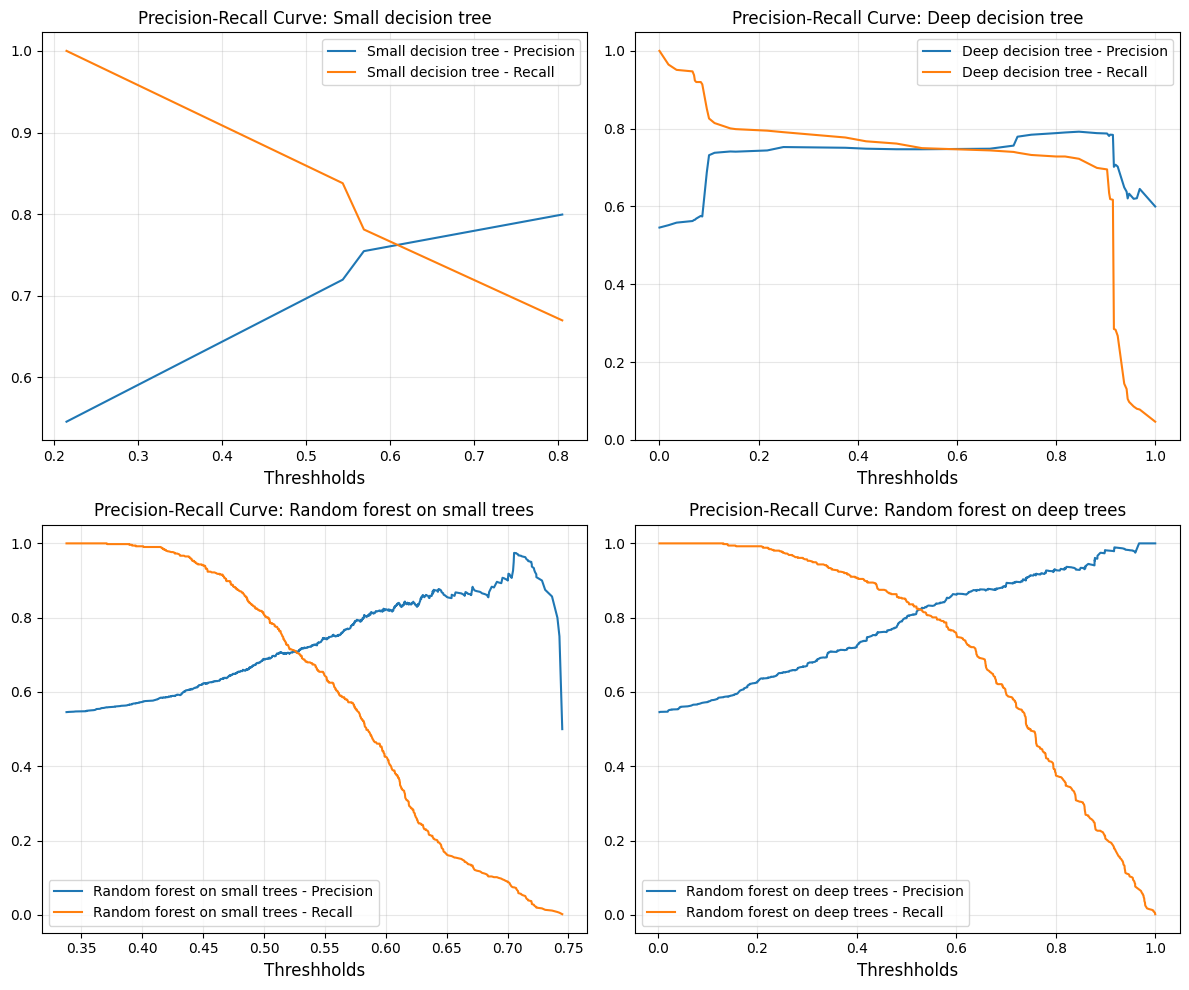

In [ ]:
# Part 3
# Precision-Recall curves

n_models = len(models.keys())
n_cols = 2
n_rows = (n_models + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 5 * n_rows))

for i, name in enumerate(models.keys(), 1):
    plt.subplot(n_rows, n_cols, i)
    precision_vals, recall_vals, thresh = precision_recall_curve(y_test, probabilities[name][:, 1])

    plt.plot(thresh, precision_vals[:-1], label=f"{name} - Precision")
    plt.plot(thresh, recall_vals[:-1], label=f"{name} - Recall")

    plt.xlabel('Threshholds', fontsize=12)
    plt.title(f'Precision-Recall Curve: {name}', fontsize=12)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

(0.0, 1.05)

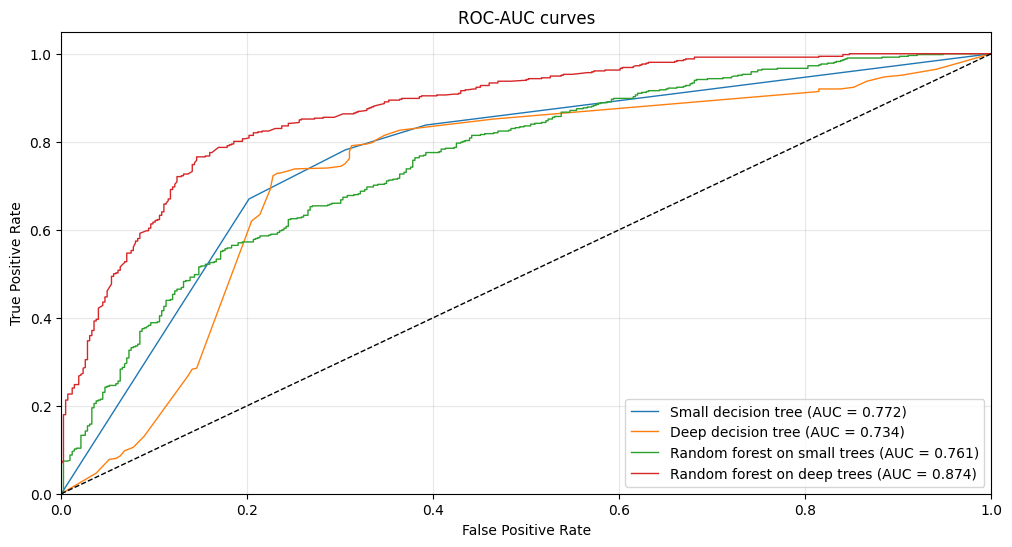

In [ ]:
# ROC curves
plt.figure(figsize=(12, 6))
for name in models.keys():
    fpr, tpr, thr = roc_curve(y_test, probabilities[name][:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=1)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curves')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

In [ ]:
# Part 4
# Let's modify one of the classifiers to minimise (avoid) False Negative errors
# Consider Random forest with deep trees and balanced classes
optimized_high_recall_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight={0: 1, 1: 34},
    random_state=123,
    n_jobs=-1
)

optimized_high_recall_clf.fit(X_train, y_train)
optimized_pred = optimized_high_recall_clf.predict(X_test)
optimized_proba = optimized_high_recall_clf.predict_proba(X_test)

# Metrics
opt_accuracy = accuracy_score(y_test, optimized_pred)
opt_precision = precision_score(y_test, optimized_pred)
opt_recall = recall_score(y_test, optimized_pred)
opt_f1 = f1_score(y_test, optimized_pred)
opt_logloss = log_loss(y_test, optimized_proba)

print(f"Accuracy:    {opt_accuracy:.4f}")
print(f"Precision:   {opt_precision:.4f}")
print(f"Recall:      {opt_recall:.4f}")
print(f"F1-score:    {opt_f1:.4f}")
print(f"Log-loss:    {opt_logloss:.4f}")

Accuracy:    0.6322
Precision:   0.6022
Recall:      0.9609
F1-score:    0.7404
Log-loss:    0.7029


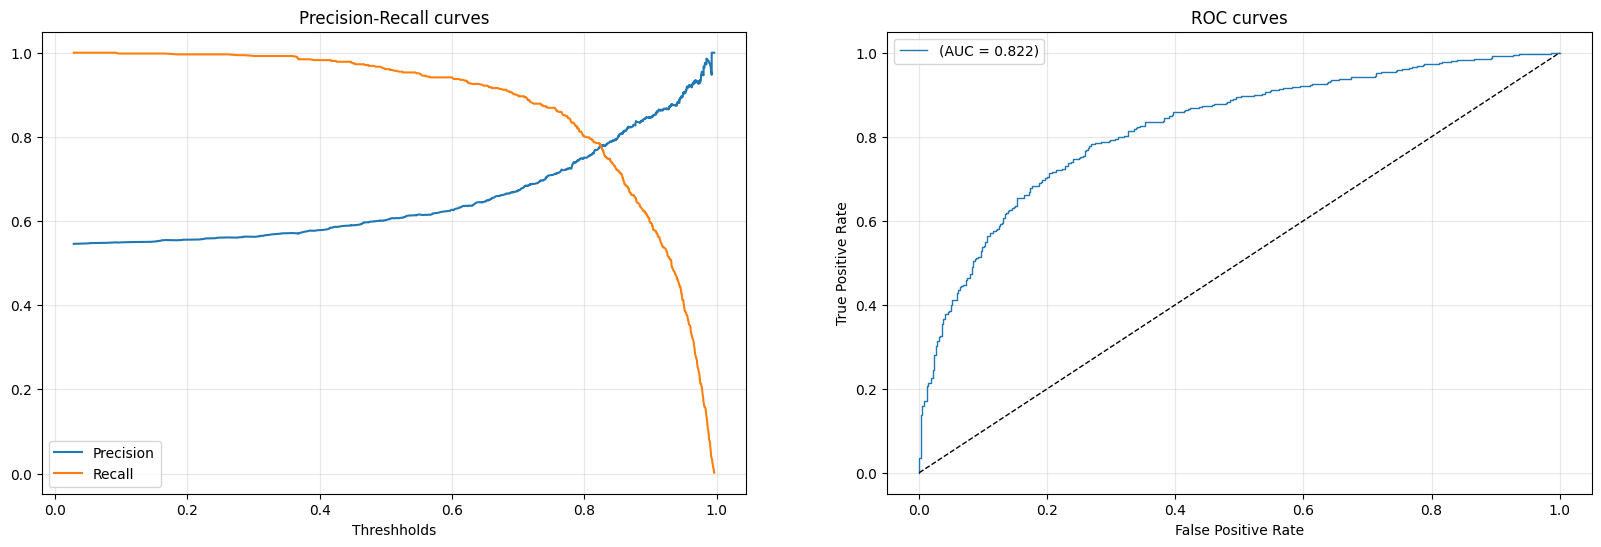

In [ ]:
# Add the curves for clarity
# Precision-Recall curve
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
precision_vals, recall_vals, thresh = precision_recall_curve(y_test, optimized_proba[:, 1])
plt.plot(thresh, precision_vals[:-1], label="Precision")
plt.plot(thresh, recall_vals[:-1], label="Recall")

plt.xlabel('Threshholds')
plt.title('Precision-Recall curves')
plt.legend()
plt.grid(True, alpha=0.3)

# ROC curve
plt.subplot(1, 2, 2)

fpr, tpr, thr = roc_curve(y_test, optimized_proba[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'(AUC = {roc_auc:.3f})', linewidth=1)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend()
plt.grid(True, alpha=0.3)


In [ ]:
# Let's use another classifier - Logistic regression, just to compare metrics results
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Minimize FN
log_reg = LogisticRegression(
    class_weight={0: 1, 1: 10},
    random_state=123,
    max_iter=1000,
    C=0.1
)

log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_pred_proba = log_reg.predict_proba(X_test)


In [ ]:
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
log_reg_precision = precision_score(y_test, log_reg_pred)
log_reg_recall = recall_score(y_test, log_reg_pred)
log_reg_f1 = f1_score(y_test, log_reg_pred)
log_reg_logloss = log_loss(y_test, log_reg_pred)

print(f"Accuracy:  {log_reg_accuracy:.4f}")
print(f"Precision: {log_reg_precision:.4f}")
print(f"Recall:    {log_reg_recall:.4f}")
print(f"F1-score:  {log_reg_f1:.4f}")
print(f"Log-loss:  {log_reg_logloss:.4f}") # Here we got too large Log-loss score despite the fact that the class ratio is smaller then one used for Random forest with deep trees that is not quite good for the classifier



Accuracy:  0.6727
Precision: 0.6319
Recall:    0.9590
F1-score:  0.7618
Log-loss:  11.7968
